In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()

In [4]:
import sys
sys.path.append('..')

from src.configs import config
from src.utils import cross_val as cv

%load_ext autoreload
%autoreload 2

# 1. Load Data
---

In [5]:
data = pd.read_csv('data/oasis_longitudinal.csv')
data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


# Kaplan-Meier

In [6]:
def KM(df):
    steps = list()
    c = 1
    for age in sorted(df.Age.unique()):
        a = df[df.Age == age].Group == 'Demented'
        roi = (df.Age == age) | (df.Age >= age) & (df.Group != 'Demented')
        c *= 1 - a.sum() / roi.sum()
        steps.append(c)
    return steps

In [7]:
def ci(df):
    steps = list()
    n = 1000
    ages = sorted(df.Age.unique())
    scores = np.zeros((n, len(ages)))

    for i in range(n):
        idxs = np.random.choice(df.index, size=df.size - 20)
        steps = KM(df.loc[idxs])
        roi = sorted(df.loc[idxs].Age.unique())
        score = list()
        k = 0
        for a in ages:
            if a in roi: 
                score.append(steps[k])
                k += 1
            else: score.append(-1)
        scores[i] = np.array(score)

    lscore = np.zeros(len(ages))
    hscore = np.zeros(len(ages))
    for i in range(scores.shape[-1]):
        roi = scores[:, i]
        hscore[i] = np.percentile(roi[roi != -1], 99)
        lscore[i] = np.percentile(roi[roi != -1], 1)
    return hscore, lscore

Text(0, 0.5, 'Percent Nondemented')

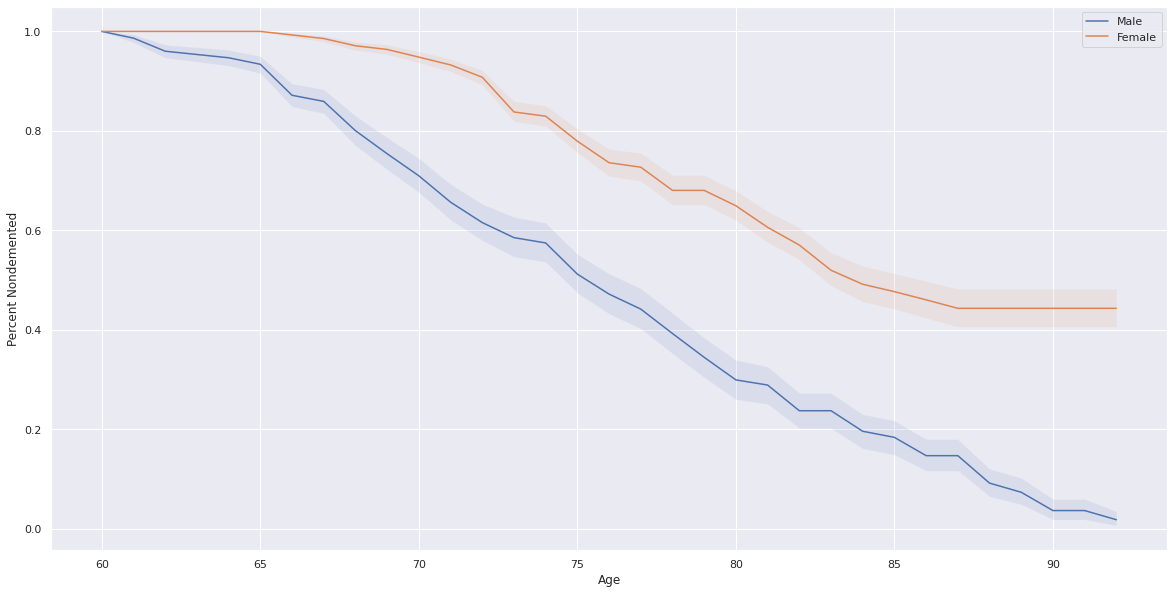

In [8]:
plt.figure(figsize=(20, 10))
df = data[data['M/F'] == 'M']
steps = np.array(KM(df))
ages = np.array(sorted(df.Age.unique()))
roi = ages <= 92
plt.plot(ages[roi], steps[roi], label='Male')
hscore, lscore = ci(df)
plt.fill_between(
    ages[roi], lscore[roi], hscore[roi], alpha=.1)


df = data[data['M/F'] != 'M']
steps = np.array(KM(df))
ages = np.array(sorted(df.Age.unique()))
roi = ages <= 92
plt.plot(ages[roi], steps[roi], label='Female')
hscore, lscore = ci(df)
plt.fill_between(
    ages[roi], lscore[roi], hscore[roi], alpha=.1)

plt.legend()
plt.xlabel('Age')
plt.ylabel('Percent Nondemented')

# Cox Proportional Hazards model

In [9]:
df = data[['Group', 'M/F',
       'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']]

In [10]:
df.SES[df.SES.isna()] = -1
df.MMSE[df.MMSE.isna()] = -1
df.ASF *= 10
df.nWBV *= 10
df

,Group,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,1987,6.96,8.83
1,Nondemented,M,88,14,2.0,30.0,2004,6.81,8.76
2,Demented,M,75,12,-1.0,23.0,1678,7.36,10.46
3,Demented,M,76,12,-1.0,28.0,1738,7.13,10.10
4,Demented,M,80,12,-1.0,22.0,1698,7.01,10.34
...,...,...,...,...,...,...,...,...,...
368,Demented,M,82,16,1.0,28.0,1693,6.94,10.37
369,Demented,M,86,16,1.0,26.0,1688,6.75,10.40
370,Nondemented,F,61,13,2.0,30.0,1319,8.01,13.31
371,Nondemented,F,63,13,2.0,30.0,1327,7.96,13.23


In [13]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
df['M/F'] = df['M/F'].replace(['F','M'], [0,1]) # M/F column
df['Group'] = df['Group'].replace(['Converted'], ['Demented']) # Target variable
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable
cph.fit(df, 'Age', event_col='Group')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 373 total observations, 190 right-censored observations>
             duration col = 'Age'
                event col = 'Group'
      baseline estimation = breslow
   number of observations = 373
number of events observed = 183
   partial log-likelihood = -861.50
         time fit was run = 2022-07-25 18:21:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
M/F         0.99       2.70       0.18             0.64             1.35                 1.89                 3.86
EDUC        0.00       1.00       0.03            -0.06             0.06                 0.95                 1.06
SES        -0.04       0.96       0.07            -0.17             0.08                 0.84                 1.09
MMSE       -0.13       0.88       0.02            -0.16            -0.10                 0.85                 0.91
eTIV       -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
nWBV        1.30       3.68       0.26             0.80             1.81                 2.22                 6.10
ASF        -1.67       0.19       0.45            -2.56            -0.78                 0.08                 0.46

            cmp to     z      p   -log2(p)
covariate                                 
M/F           0.00  5.46 <0.005      24.33
EDUC          0.00  0.03   0.98       0.03
SES           0.00 -0.69   0.49       1.02
MMSE          0.00 -8.22 <0.005      52.17
eTIV          0.00 -3.87 <0.005      13.18
nWBV          0.00  5.04 <0.005      21.06
ASF           0.00 -3.68 <0.005      12.09
---
Concordance = 0.72
Partial AIC = 1737.00
log-likelihood ratio test = 106.39 on 7 df
-log2(p) of ll-ratio test = 64.07

In [14]:
cph.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 7
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
         106.39 <0.005     64.07

<AxesSubplot:xlabel='log(HR) (95% CI)'>

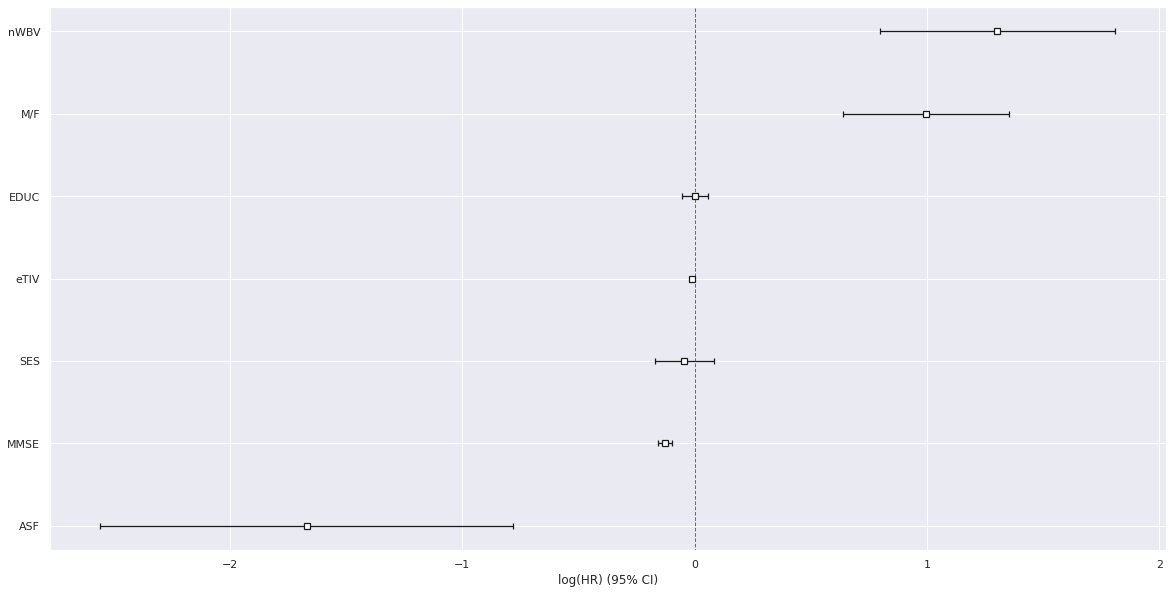

In [15]:
plt.figure(figsize=(20,10))
cph.plot()

Text(0.5, 0, 'Age')

<Figure size 1440x720 with 0 Axes>

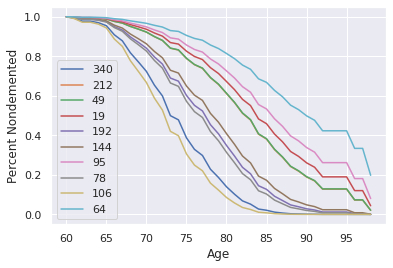

In [ ]:
plt.figure(figsize=(20,10))
idxs = np.random.choice(df.index, size=10)
cph.predict_survival_function(df.iloc[idxs]).plot()
plt.ylabel('Percent Nondemented')
plt.xlabel('Age')

# Generalised Linear Models

In [17]:
df = data.copy()

df.SES[df.SES.isna()] = -1
df.MMSE[df.MMSE.isna()] = -1
df.ASF *= 10
df.nWBV *= 10

In [18]:
scolumns = ['eTIV', 'nWBV']#, 'ASF']

df[['T{}'.format(s) for s in scolumns]] = 0
for sid, idxs in df.groupby('Subject ID').groups.items():
    a = df.loc[idxs]
    min_i, max_i = np.argmin(a['MR Delay']), np.argmax(a['MR Delay'])
    s = np.abs(a.iloc[max_i][scolumns] / a.iloc[min_i][scolumns])# / a.iloc[max_i]['MR Delay']
    for sc in scolumns:
        df.loc[idxs, 'T{}'.format(sc)] = np.log(s[sc])

In [19]:
df = df.loc[df['Visit']==1] # use first visit data only because of the analysis we're doing
df = df.reset_index(drop=True) # reset index after filtering first visit data
df['M/F'] = df['M/F'].replace(['F','M'], [0,1]) # M/F column

In [20]:
df[df.Group == 'Converted']

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,TeTIV,TnWBV
13,OAS2_0018,OAS2_0018_MR1,Converted,1,0,0,R,87,14,1.0,30.0,0.0,1406,7.15,12.48,0.012019,-0.026933
14,OAS2_0020,OAS2_0020_MR1,Converted,1,0,1,R,80,20,1.0,29.0,0.0,1587,6.93,11.06,0.006281,-0.039740
23,OAS2_0031,OAS2_0031_MR1,Converted,1,0,0,R,86,12,3.0,30.0,0.0,1430,7.18,12.27,0.022815,-0.031120
31,OAS2_0041,OAS2_0041_MR1,Converted,1,0,0,R,71,16,1.0,27.0,0.0,1289,7.71,13.62,0.019209,-0.014370
44,OAS2_0054,OAS2_0054_MR1,Converted,1,0,0,R,85,18,1.0,29.0,0.0,1264,7.01,13.88,0.008665,-0.026013
75,OAS2_0092,OAS2_0092_MR1,Converted,1,0,0,R,83,12,2.0,28.0,0.0,1383,7.48,12.69,0.005049,-0.027102
85,OAS2_0103,OAS2_0103_MR1,Converted,1,0,0,R,69,16,1.0,30.0,0.0,1404,7.50,12.50,0.010627,-0.025660
97,OAS2_0118,OAS2_0118_MR1,Converted,1,0,0,R,67,14,4.0,30.0,0.0,1508,7.94,11.64,0.013830,-0.007585
104,OAS2_0127,OAS2_0127_MR1,Converted,1,0,1,R,79,18,1.0,29.0,0.0,1644,7.29,10.67,0.015691,-0.085890
107,OAS2_0131,OAS2_0131_MR1,Converted,1,0,0,R,65,12,2.0,30.0,0.5,1340,7.54,13.09,-0.006739,0.009241


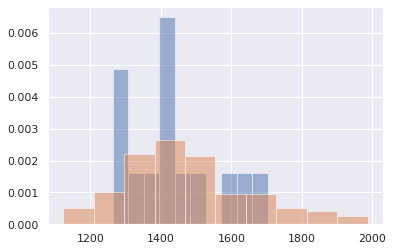

In [21]:
plt.hist(df[df.Group == 'Converted'].eTIV, density=True, alpha=.5);
plt.hist(df[df.Group != 'Converted'].eTIV, density=True, alpha=.5);

In [22]:
df['Group'] = df['Group'].replace(['Converted'], ['Demented']) # Target variable
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable
df = df.drop(['MRI ID', 'Subject ID', 'CDR', 'MR Delay', 'Visit', 'Hand'], axis=1) # Drop unnecessary columns

In [23]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X = df.drop([
    'Group', 
    'ASF', *['T{}'.format(sc) for sc in scolumns]
], axis=1)
y = df['Group'].astype(np.bool)

X.SES += 1
X = np.log(X + 1e-5)
X = (X - X.mean()) / X.std()
X['AgeNeTIV'] = X.Age * X.eTIV

X2 = sm.add_constant(X)
est = sm.Logit(y, X2)
est2 = est.fit()
print(est2.summary(alpha=.05))

Optimization terminated successfully.
         Current function value: 0.410159
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  Group   No. Observations:                  150
Model:                          Logit   Df Residuals:                      141
Method:                           MLE   Df Model:                            8
Date:                Mon, 25 Jul 2022   Pseudo R-squ.:                  0.4076
Time:                        18:23:04   Log-Likelihood:                -61.524
converged:                       True   LL-Null:                       -103.85
Covariance Type:            nonrobust   LLR p-value:                 5.623e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2565      0.800      2.822      0.005       0.689       3.824
M/F            0.7148      0

In [24]:
import xgboost

cross = cv.CrossVal(X, y.astype(np.bool))
xgb_init = lambda: xgboost.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_models = cross.cross_val(xgb_init)

ModuleNotFoundError: No module named 'xgboost'

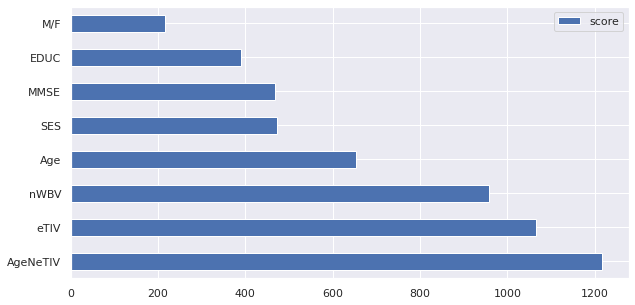

In [22]:
from collections import defaultdict

feature_important = [ 
    m.get_booster().get_score(importance_type='weight')
    for m in xgb_models
]
fikv = defaultdict(int)
for fi in feature_important:
    for k, v in fi.items():
        fikv[k] += v

data = pd.DataFrame(
    data=list(fikv.values()), index=list(fikv.keys()), 
    columns=["score"]).sort_values(by = "score", ascending=False)
data[data.score > 1].plot(kind='barh', figsize=(10, 5));

10it [00:00, 93.30it/s]


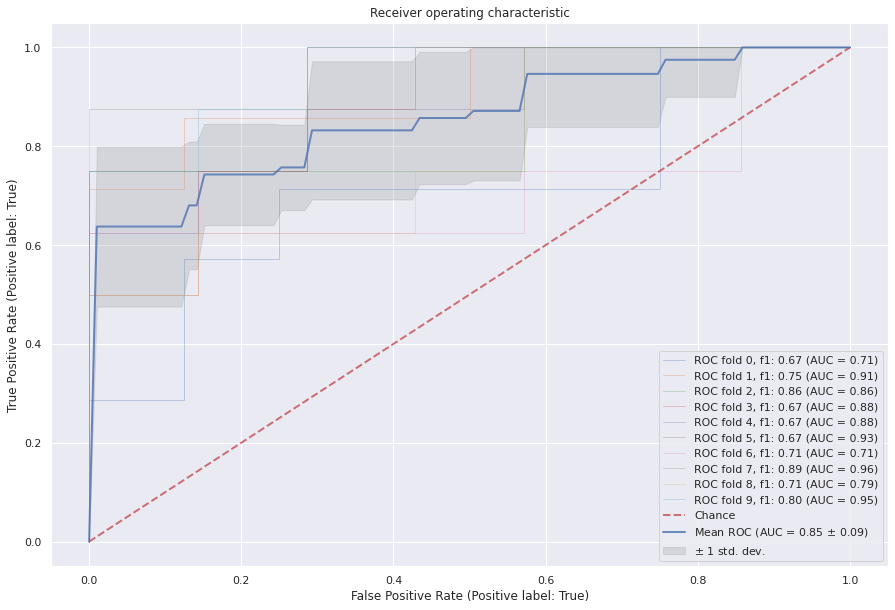

In [25]:
from sklearn.linear_model import LogisticRegression

# ndatasets = np.log(datasets + 1e-5)
# ndatasets = (ndatasets - ndatasets.mean()) / ndatasets.std()

cross = cv.CrossVal(X, y)
lr_init = lambda: LogisticRegression(random_state=42)
lr_models = cross.cross_val(lr_init)

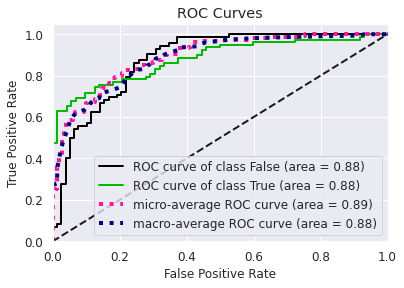

In [24]:
import scikitplot as skplt
import matplotlib.pyplot as plt


pred = (est2.predict(X2))
pred = pred.values
pred = np.stack([1 - pred, pred], -1)
skplt.metrics.plot_roc_curve(y.values, pred)
plt.show()

In [44]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix
import pandas as pd

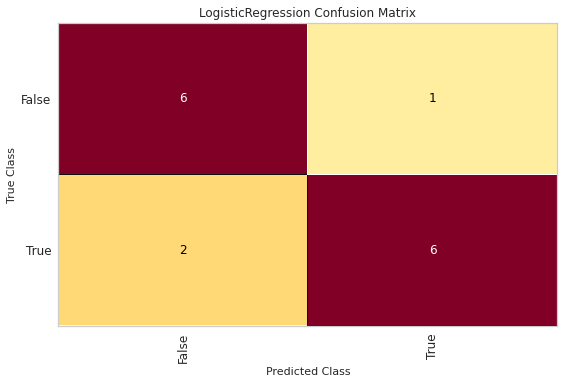

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [45]:
sv = ConfusionMatrix(lr_models[-1][0])
X, y = cross._datasets.iloc[lr_models[-1][1]], cross._metas.iloc[lr_models[-1][1]]
sv.fit(X, y)
X, y = cross._datasets.iloc[lr_models[-1][2]], cross._metas.iloc[lr_models[-1][2]]
sv.score(X, y)
sv.poof()

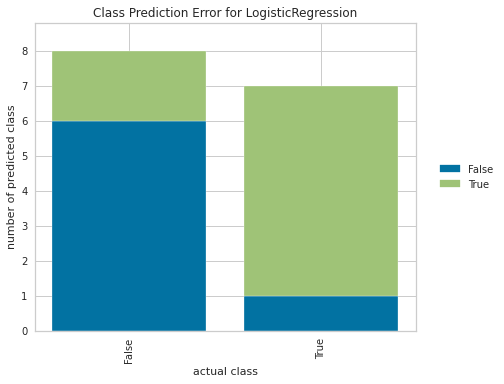

<AxesSubplot:title={'center':'Class Prediction Error for LogisticRegression'}, xlabel='actual class', ylabel='number of predicted class'>

In [39]:
sv = ClassPredictionError(lr_models[-1][0])
X, y = cross._datasets.iloc[lr_models[-1][1]], cross._metas.iloc[lr_models[-1][1]]
sv.fit(X, y)
X, y = cross._datasets.iloc[lr_models[-1][2]], cross._metas.iloc[lr_models[-1][2]]
sv.score(X, y)
sv.poof()

In [273]:
lm = LinearRegression()
lm.fit(X,y)

params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(X)

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
print(myDF3)

LinAlgError: Singular matrix

### Feature importance investigation should be performed for that perfect score
While no data folds' overlaps were found even on patient-id level

In [192]:
est2.pearson_chi2

59.76041808658317

In [36]:
from lifelines import KaplanMeierFitter

In [38]:
km = KaplanMeierFitter()

In [ ]:
kmf.fit(durations, event_observed,label='Kaplan Meier Estimate')

In [6]:
df = df.loc[df['Visit']==1] # use first visit data only because of the analysis we're doing
df = df.reset_index(drop=True) # reset index after filtering first visit data
df['M/F'] = df['M/F'].replace(['F','M'], [0,1]) # M/F column
df['Group'] = df['Group'].replace(['Converted'], ['Demented']) # Target variable
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable
df = df.drop(['MRI ID', 'Visit', 'Hand'], axis=1) # Drop unnecessary columns

In [14]:
df['MRI ID']

0      OAS2_0001_MR1
1      OAS2_0001_MR2
2      OAS2_0002_MR1
3      OAS2_0002_MR2
4      OAS2_0002_MR3
           ...      
368    OAS2_0185_MR2
369    OAS2_0185_MR3
370    OAS2_0186_MR1
371    OAS2_0186_MR2
372    OAS2_0186_MR3
Name: MRI ID, Length: 373, dtype: object

Text(0.5, 1.0, 'Gender and Demented rate')

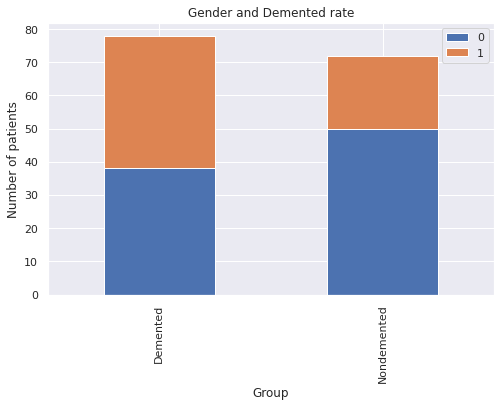

In [7]:
# bar drawing function
def bar_chart(feature):
    Demented = df[df['Group']==1][feature].value_counts()
    Nondemented = df[df['Group']==0][feature].value_counts()
    df_bar = pd.DataFrame([Demented,Nondemented])
    df_bar.index = ['Demented','Nondemented']
    df_bar.plot(kind='bar',stacked=True, figsize=(8,5))

# Gender  and  Group ( Femal=0, Male=1)
bar_chart('M/F')
plt.xlabel('Group')
plt.ylabel('Number of patients')
plt.legend()
plt.title('Gender and Demented rate')

In [9]:
df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


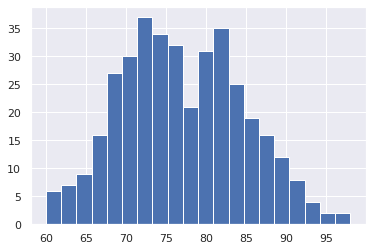

In [10]:
plt.hist(df.Age, 20);
df.Age.value_counts();

(15.3, 30.0)

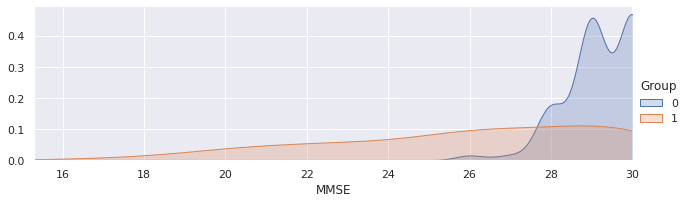

In [9]:
#MMSE : Mini Mental State Examination
# Nondemented = 0, Demented =1
# Nondemented has higher test result ranging from 25 to 30. 
#Min 17 ,MAX 30
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'MMSE',shade= True)
facet.set(xlim=(0, df['MMSE'].max()))
facet.add_legend()
plt.xlim(15.30)

The chart shows Nondemented group got much more higher MMSE scores than Demented group.

(0.6, 0.9)

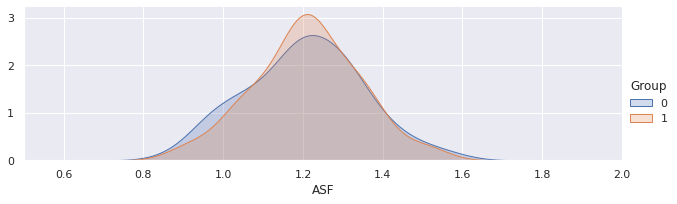

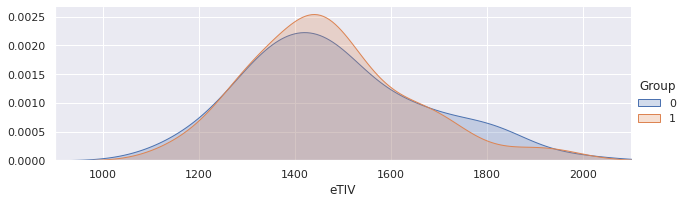

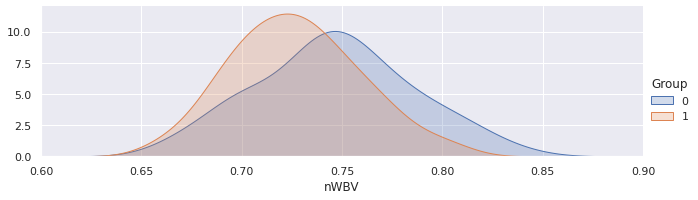

In [10]:
#bar_chart('ASF') = Atlas Scaling Factor
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'ASF',shade= True)
facet.set(xlim=(0, df['ASF'].max()))
facet.add_legend()
plt.xlim(0.5, 2)

#eTIV = Estimated Total Intracranial Volume
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'eTIV',shade= True)
facet.set(xlim=(0, df['eTIV'].max()))
facet.add_legend()
plt.xlim(900, 2100)

#'nWBV' = Normalized Whole Brain Volume
# Nondemented = 0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'nWBV',shade= True)
facet.set(xlim=(0, df['nWBV'].max()))
facet.add_legend()
plt.xlim(0.6,0.9)

There is a higher concentration of 70-80 years old in the Demented patient group than those in the nondemented patients. We guess patients who suffered from that kind of disease has lower survival rate so that there are a few of 90 years old.

(0.0, 0.16)

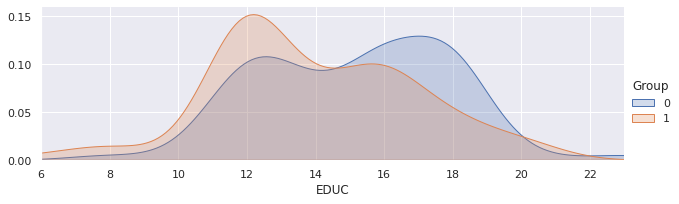

In [11]:
#'EDUC' = Years of Education
# Nondemented = 0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'EDUC',shade= True)
facet.set(xlim=(df['EDUC'].min(), df['EDUC'].max()))
facet.add_legend()
plt.ylim(0, 0.16)

## Intermediate Result Summary
1. Men are more likely with demented, an Alzheimer's Disease, than Women.
2. Demented patients were less educated in terms of years of education.
3. Nondemented group has higher brain volume than Demented group.
4. Higher concentration of 70-80 years old in Demented group than those in the nondemented patients.

## We can investigate the descripancy bw different brain measurments

In [11]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


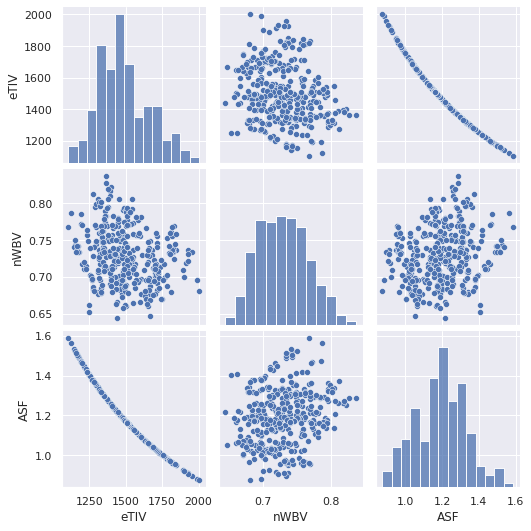

In [12]:
g = sns.pairplot(df[['eTIV', 'nWBV', 'ASF']])
plt.show()

On this plot, as well as from definition, eTIV & ASF variables are mutually determinable, thus bring no additional information (further only ASF will be used in analisys).

# MR & PET Exploration 

In [15]:
import nibabel as nib
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from skimage import measure

def plot_3d(image, threshold=-300): 
    p = image.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.0001)
    face_color = [1, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [16]:
scan = nib.load('../data/OASIS/OAS30001_MR_d0129/anat1/NIFTI/sub-OAS30001_ses-d0129_acq-TSE_T2w.nii.gz')
scan = scan.get_data()

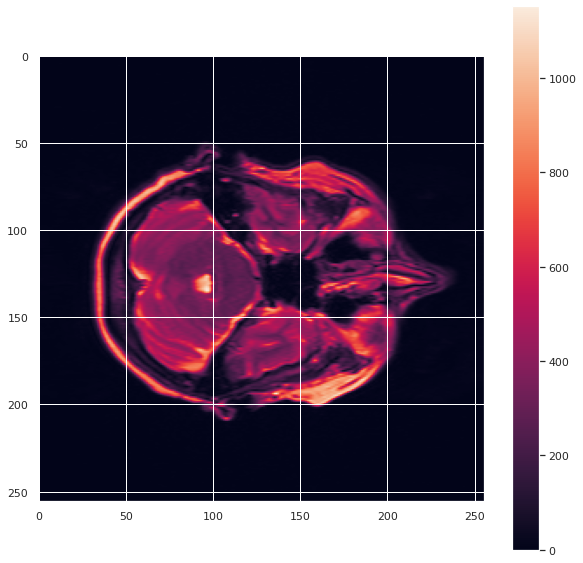

In [17]:
plt.figure(figsize=(10, 10))
a = plt.imshow(scan[..., 10])
plt.colorbar(a)

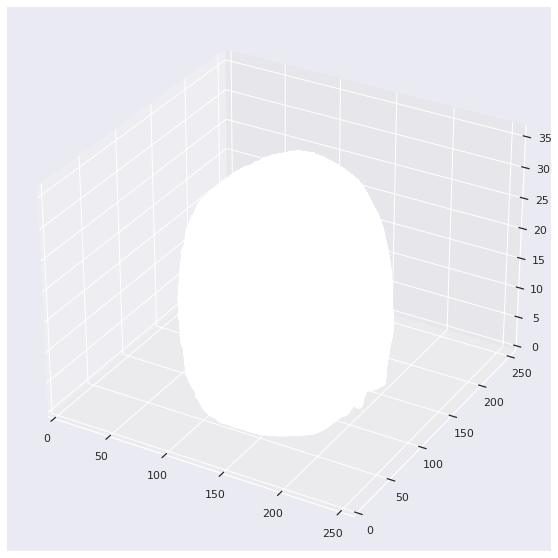

In [34]:
plot_3d(scan.T, 250)

Future work will be dedicated to analise and compare MR scans of statistical outliers